In [410]:
#theEarliertheBetter
#XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_curve, auc, roc_auc_score)
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

In [411]:
#importing the data

data = pd.read_csv('/Users/cmoradajr/Downloads/The_Cancer_data_1500_V2.csv')
data.head(5)

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


In [412]:
#describing the data
print("Descriptive Statistics:")
data.describe()

Descriptive Statistics:


,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,50.320000,0.490667,27.513321,0.269333,0.508667,4.897929,2.417987,0.144000,0.371333
std,17.640968,0.500080,7.230012,0.443761,0.678895,2.866162,1.419318,0.351207,0.483322
min,20.000000,0.000000,15.000291,0.000000,0.000000,0.002410,0.001215,0.000000,0.000000
25%,35.000000,0.000000,21.483134,0.000000,0.000000,2.434609,1.210598,0.000000,0.000000
50%,51.000000,0.000000,27.598494,0.000000,0.000000,4.834316,2.382971,0.000000,0.000000
75%,66.000000,1.000000,33.850837,1.000000,1.000000,7.409896,3.585624,0.000000,1.000000
max,80.000000,1.000000,39.958688,1.000000,2.000000,9.994607,4.987115,1.000000,1.000000


In [413]:
#checking the correlation
data_corr = data.corr()
data_corr

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
Age,1.000000,0.007145,0.030246,-0.013914,-0.027025,0.016396,0.003209,-0.010996,0.196603
Gender,0.007145,1.000000,-0.012516,0.035384,-0.004674,0.023401,0.009723,0.007657,0.250336
BMI,0.030246,-0.012516,1.000000,-0.012616,0.011392,0.011480,0.004711,-0.010824,0.187560
Smoking,-0.013914,0.035384,-0.012616,1.000000,-0.021039,-0.043817,-0.001660,0.016368,0.226999
GeneticRisk,-0.027025,-0.004674,0.011392,-0.021039,1.000000,-0.039721,-0.016864,-0.010833,0.253472
PhysicalActivity,0.016396,0.023401,0.011480,-0.043817,-0.039721,1.000000,0.033856,0.018136,-0.150089
AlcoholIntake,0.003209,0.009723,0.004711,-0.001660,-0.016864,0.033856,1.000000,0.055403,0.212772
CancerHistory,-0.010996,0.007657,-0.010824,0.016368,-0.010833,0.018136,0.055403,1.000000,0.392188
Diagnosis,0.196603,0.250336,0.187560,0.226999,0.253472,-0.150089,0.212772,0.392188,1.000000


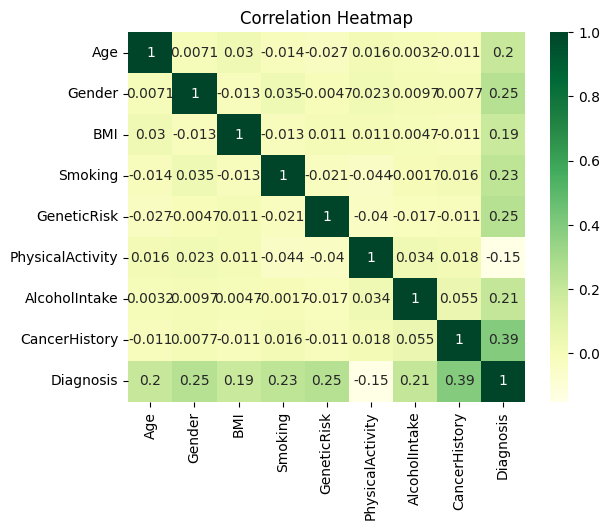

In [414]:
#visualizing the correlation using heatmap
sns.heatmap(data_corr, annot = True, cmap = 'YlGn')
plt.title("Correlation Heatmap")
plt.show()

In [415]:
#defining the variables
X = data.drop('Diagnosis', axis = 1)
y = data['Diagnosis']

In [416]:
#splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 45, stratify= y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (1200, 8)
Test set: (300, 8)


In [417]:
#Define Xboost model

xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False)

In [418]:
#hyperparameter space for RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}


In [419]:
#randomized search CV

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,           # number of parameter settings sampled
    scoring='recall',
    cv=5,                # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1          # use all cores
)

In [420]:
#fit the randomized search

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARN

[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARN

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, reg_alpha=0.01, reg_lambda=3, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, n_est

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARN

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, n_esti

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARN

[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rat

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARN

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1, reg_lambda=3, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=4, n_estimators=500, reg_alpha=0.1, reg_lambda=3, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.2, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.2, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4,

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARN

[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.1, max_depth=6, n_estimators=400, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_dep

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARN

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=400, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=500, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0, reg_lambda=3, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1.5, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_est

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:49] WARN

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.7, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,50
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [421]:
#best parameter and model

print("Best Parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

Best Parameters: {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}


In [422]:
# Initial Predictions
y_pred_initial = best_model.predict(X_test)

# Initial Evaluation
print("\n📊 Initial Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_initial))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_initial))
print("\nClassification Report:\n", classification_report(y_test, y_pred_initial))


📊 Initial Model Performance:
Accuracy: 0.94

Confusion Matrix:
 [[182   7]
 [ 11 100]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       189
           1       0.93      0.90      0.92       111

    accuracy                           0.94       300
   macro avg       0.94      0.93      0.94       300
weighted avg       0.94      0.94      0.94       300



In [423]:
#Final model with best parameters

final_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.6,
    colsample_bytree=0.7,
    gamma=0.3,
    reg_alpha=1,
    reg_lambda=3,
    eval_metric="logloss",
    use_label_encoder=False
)

final_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [424]:
#cross validation on final model

cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='accuracy')
print("\n📊 Cross-Validation Scores:", cv_scores)
print(f"📊 Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:50:51] WARN


📊 Cross-Validation Scores: [0.94166667 0.93333333 0.90833333 0.9375     0.91666667]
📊 Mean CV Accuracy: 0.9275 (+/- 0.0128)


In [425]:
# Predict on test set
y_pred = final_model.predict(X_test)


🎯 Top 10 Most Important Features:
            feature  importance
7     CancerHistory    0.303466
4       GeneticRisk    0.181745
1            Gender    0.162369
3           Smoking    0.109277
2               BMI    0.066648
0               Age    0.062200
6     AlcoholIntake    0.059428
5  PhysicalActivity    0.054867


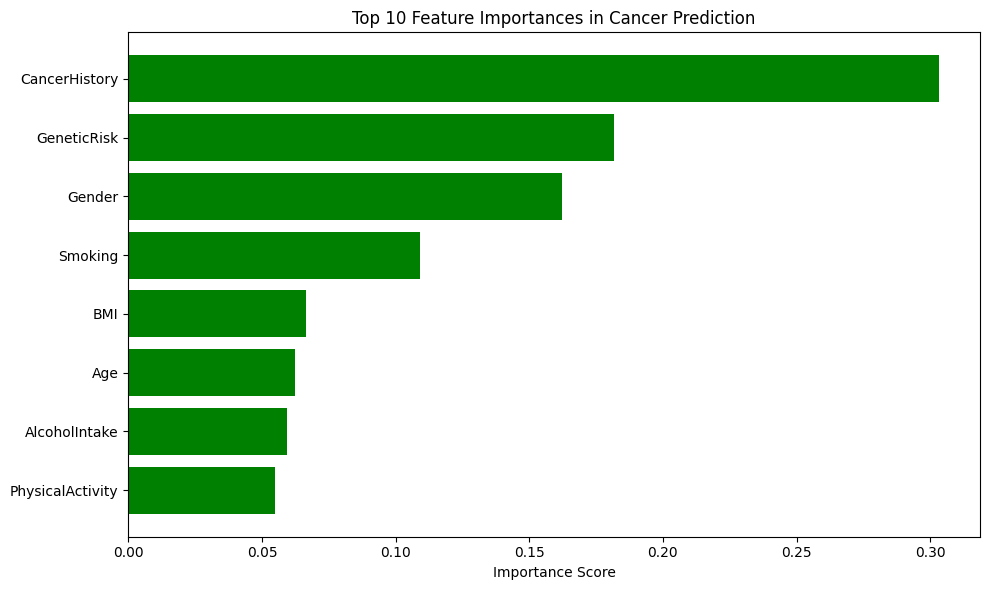

In [426]:
#feature importance

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Top 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], 
         feature_importance['importance'][:10], 
         color='green')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances in Cancer Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [427]:
# Final predictions

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

In [428]:
#Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy:  {round(accuracy * 100, 2)}%")
print(f"Precision: {round(precision * 100, 2)}%")
print(f"Recall:    {round(recall * 100, 2)}%")
print(f"F1-Score:  {round(f1 * 100, 2)}%")
print(f"ROC-AUC:   {round(roc_auc * 100, 2)}%")

print("\n📊 Confusion Matrix:\n", conf_matrix)
print("\n📄 Classification Report:\n", report)


FINAL MODEL PERFORMANCE
Accuracy:  94.0%
Precision: 93.46%
Recall:    90.09%
F1-Score:  91.74%
ROC-AUC:   97.59%

📊 Confusion Matrix:
 [[182   7]
 [ 11 100]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       189
           1       0.93      0.90      0.92       111

    accuracy                           0.94       300
   macro avg       0.94      0.93      0.94       300
weighted avg       0.94      0.94      0.94       300



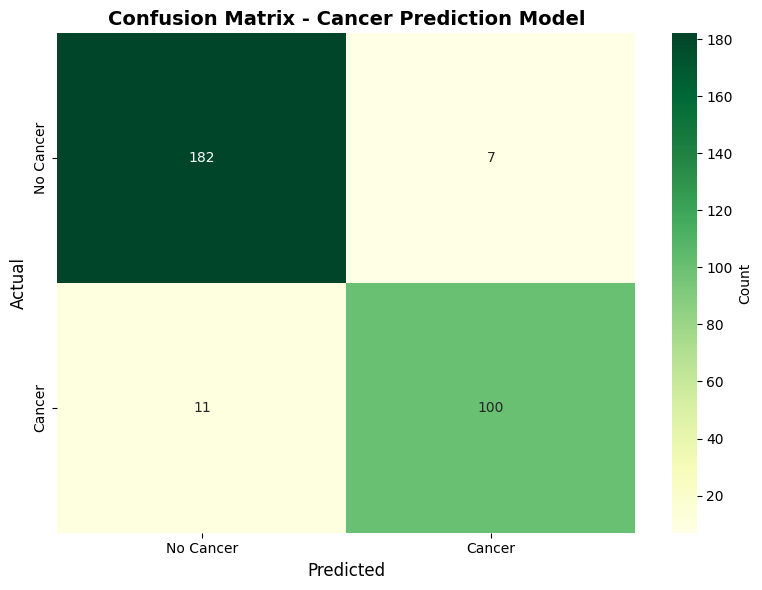

In [429]:
#visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn', 
            xticklabels=["No Cancer", "Cancer"],  
            yticklabels=["No Cancer", "Cancer"],  
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - Cancer Prediction Model", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [430]:
# Interpretation:

# The model correctly predicted 182 patients without cancer.
# It incorrectly predicted 7 patients as having cancer when they do not.
# It failed to predict 11 patients who actually had cancer.
# It correctly predicted 100 patients with cancer.

In [431]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [432]:
import shap


SHAP FEATURE IMPORTANCE VALUES
         Feature  Mean_Absolute_SHAP
          Gender            0.990047
   CancerHistory            0.925450
   AlcoholIntake            0.882871
             Age            0.848088
             BMI            0.778948
PhysicalActivity            0.678242
     GeneticRisk            0.642231
         Smoking            0.617525


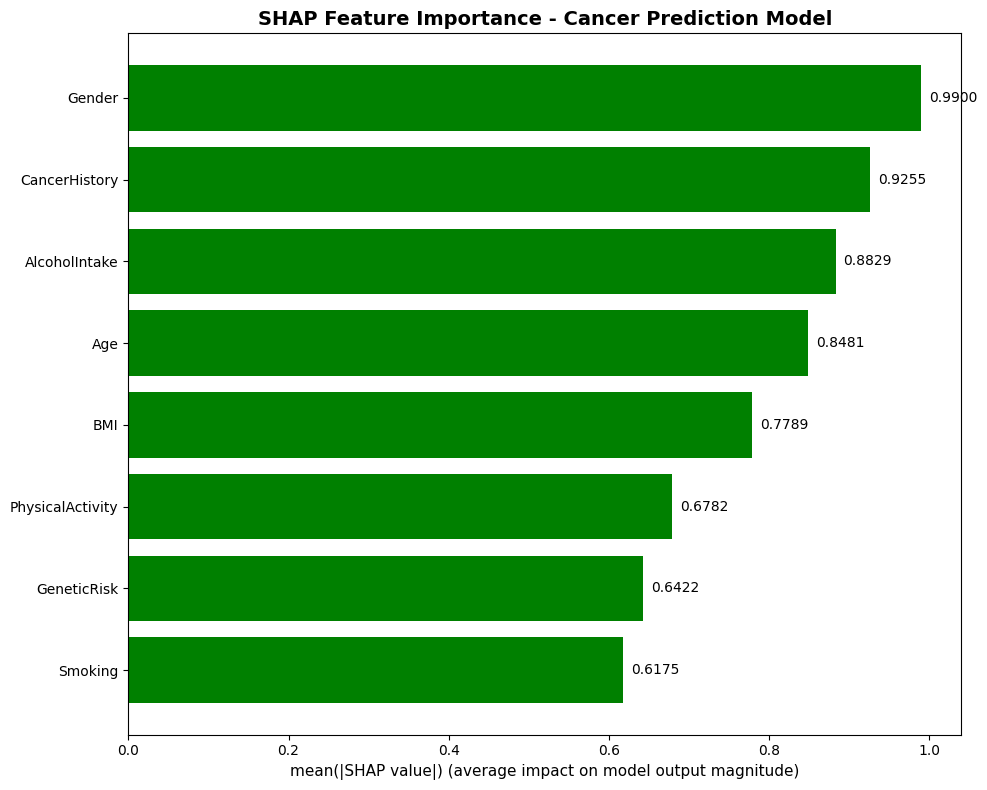

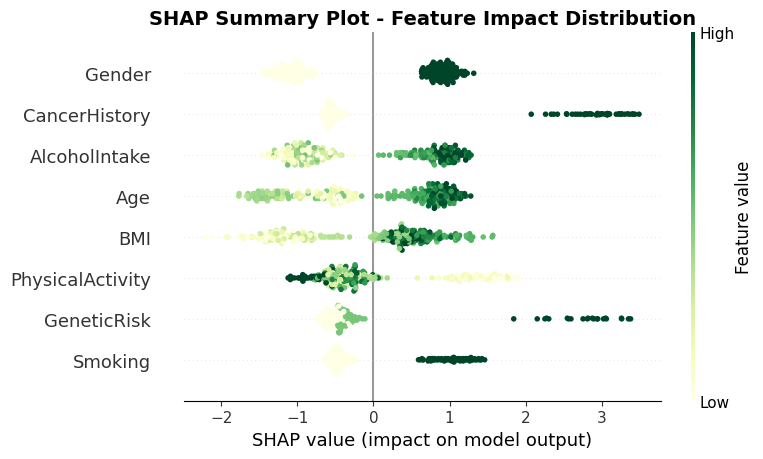


EXAMPLE: SHAP Explanation for First Test Patient


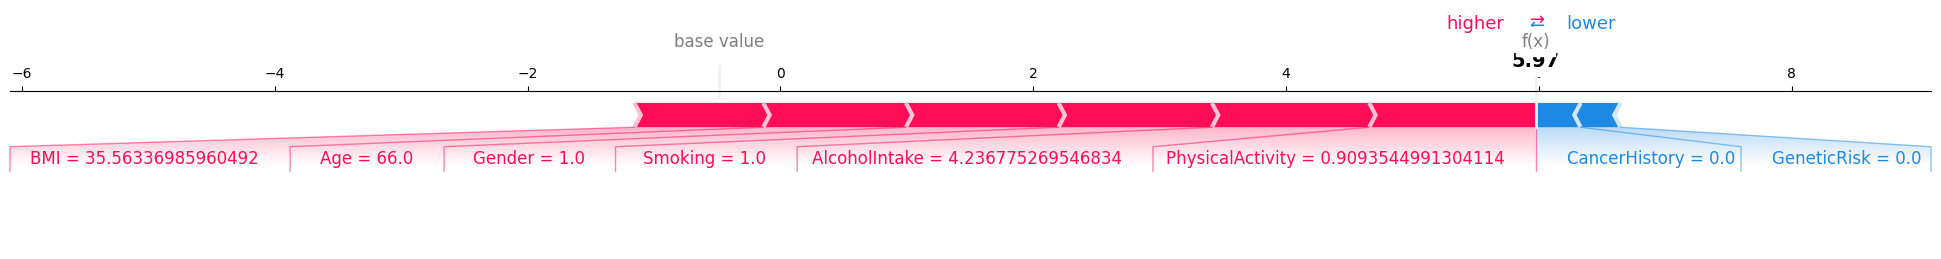


Actual Diagnosis: Cancer
Predicted Probability: 0.9975

Base Value (average model output): -0.4825

Feature Contributions (SHAP values):
         Feature     Value  SHAP Value
PhysicalActivity  0.909354    1.316468
   AlcoholIntake  4.236775    1.244412
         Smoking  1.000000    1.213255
          Gender  1.000000    1.207201
             Age 66.000000    1.128412
             BMI 35.563370    1.019260
   CancerHistory  0.000000   -0.356355
     GeneticRisk  0.000000   -0.315999

COMPARISON: XGBoost vs SHAP Feature Importance
         Feature  XGBoost_Importance  Mean_Absolute_SHAP
   CancerHistory            0.303466            0.925450
     GeneticRisk            0.181745            0.642231
          Gender            0.162369            0.990047
         Smoking            0.109277            0.617525
             BMI            0.066648            0.778948
             Age            0.062200            0.848088
   AlcoholIntake            0.059428            0.882871
Physica

<Figure size 1000x600 with 0 Axes>

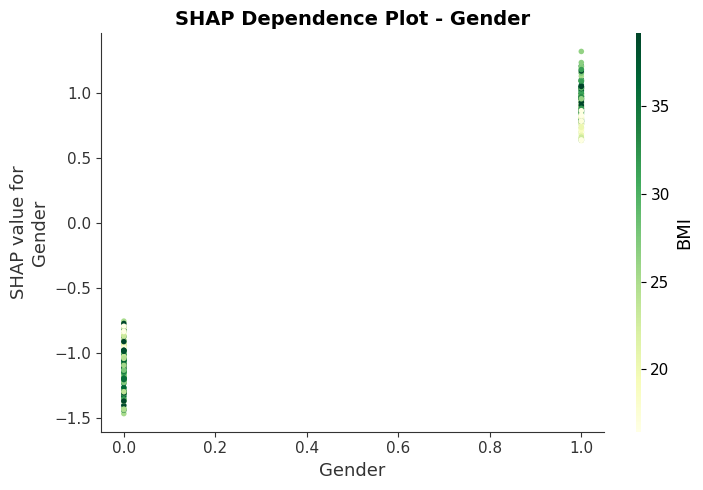

<Figure size 1000x600 with 0 Axes>

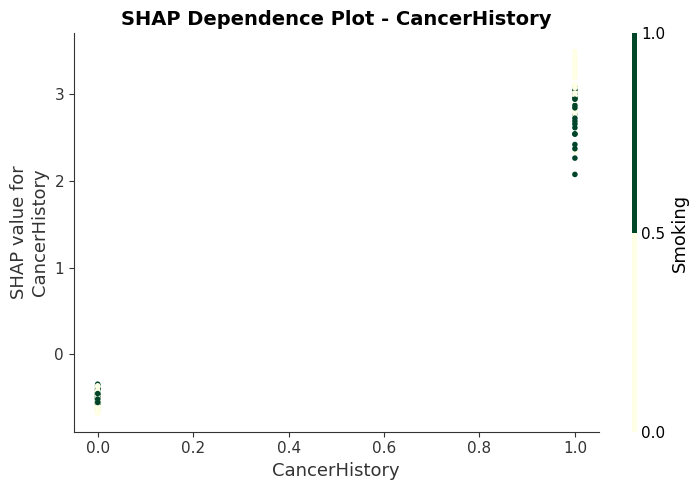

<Figure size 1000x600 with 0 Axes>

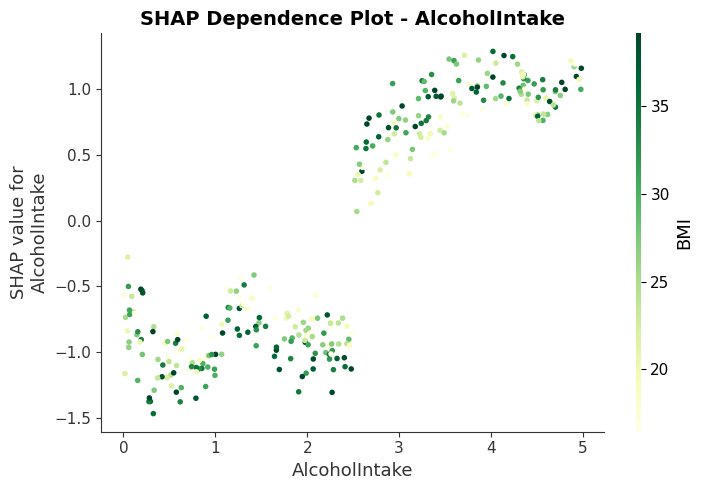

In [433]:

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)


shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Absolute_SHAP': np.abs(shap_values).mean(axis=0)
}).sort_values('Mean_Absolute_SHAP', ascending=False)

print("\n" + "="*60)
print("SHAP FEATURE IMPORTANCE VALUES")
print("="*60)
print(shap_importance.to_string(index=False))

# %%
# SHAP Feature Importance Bar Plot with Values 

plt.figure(figsize=(10, 8))
bars = plt.barh(shap_importance['Feature'], 
                shap_importance['Mean_Absolute_SHAP'], 
                color='green')
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=11)
plt.title('SHAP Feature Importance - Cancer Prediction Model', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, v in enumerate(shap_importance['Mean_Absolute_SHAP']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# %%
# SHAP Summary Plot 

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False, cmap='YlGn')
plt.title("SHAP Summary Plot - Feature Impact Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# %%
# SHAP Explanation for a Single Prediction (First Test Patient)

print("\n" + "="*60)
print("EXAMPLE: SHAP Explanation for First Test Patient")
print("="*60)

# Force plot for single prediction
shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    X_test.iloc[0],
    matplotlib=True,
    show=False
)
plt.tight_layout()
plt.show()

# Actual values and SHAP contributions
print(f"\nActual Diagnosis: {'Cancer' if y_test.iloc[0] == 1 else 'No Cancer'}")
print(f"Predicted Probability: {y_pred_proba[0]:.4f}")
print(f"\nBase Value (average model output): {explainer.expected_value:.4f}")
print("\nFeature Contributions (SHAP values):")

shap_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Value': X_test.iloc[0].values,
    'SHAP Value': shap_values[0]
}).sort_values('SHAP Value', key=abs, ascending=False)

print(shap_df.to_string(index=False))

# %%
# Comparison: XGBoost Feature Importance vs SHAP Feature Importance

print("\n" + "="*60)
print("COMPARISON: XGBoost vs SHAP Feature Importance")
print("="*60)

comparison_df = pd.DataFrame({
    'Feature': feature_importance['feature'].values,
    'XGBoost_Importance': feature_importance['importance'].values
})

comparison_df = comparison_df.merge(
    shap_importance[['Feature', 'Mean_Absolute_SHAP']], 
    on='Feature'
).sort_values('XGBoost_Importance', ascending=False)

print(comparison_df.to_string(index=False))

# %%
# SHAP Dependence Plot for Top Features 

print("\n" + "="*60)
print("SHAP DEPENDENCE PLOTS FOR TOP 3 FEATURES")
print("="*60)

top_features = shap_importance['Feature'].head(3).values

# Import colormap
from matplotlib import cm

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature, 
        shap_values, 
        X_test,
        show=False,
        cmap=cm.YlGn
    )
    plt.title(f"SHAP Dependence Plot - {feature}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


LIME (Local Interpretable Model-agnostic Explanations)

📊 LIME Explanation for First Test Patient:


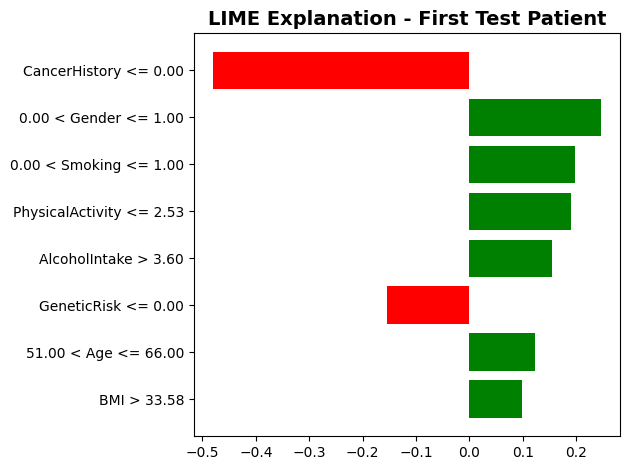


LIME Feature Weights:
CancerHistory <= 0.00: -0.4798
0.00 < Gender <= 1.00: 0.2460
0.00 < Smoking <= 1.00: 0.1984
PhysicalActivity <= 2.53: 0.1900
AlcoholIntake > 3.60: 0.1544
GeneticRisk <= 0.00: -0.1535
51.00 < Age <= 66.00: 0.1230
BMI > 33.58: 0.0986

Prediction Probabilities:
No Cancer: 0.0025
Cancer: 0.9975

LIME EXPLANATIONS FOR MULTIPLE PATIENTS

--- Patient 0 ---
Actual: Cancer
Predicted: Cancer
Probability: 0.9975


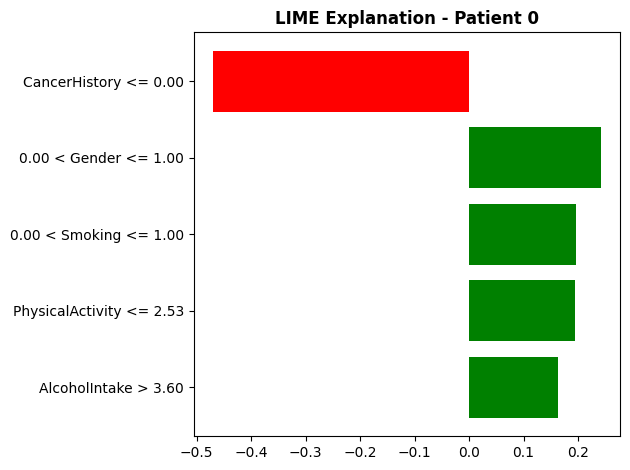


--- Patient 50 ---
Actual: No Cancer
Predicted: No Cancer
Probability: 0.1221


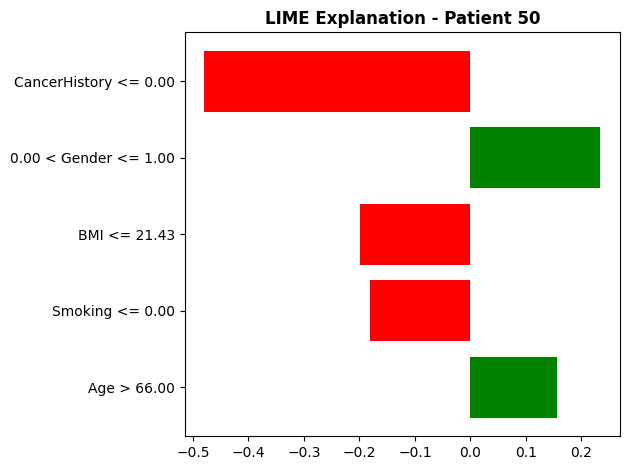


--- Patient 100 ---
Actual: No Cancer
Predicted: No Cancer
Probability: 0.0613


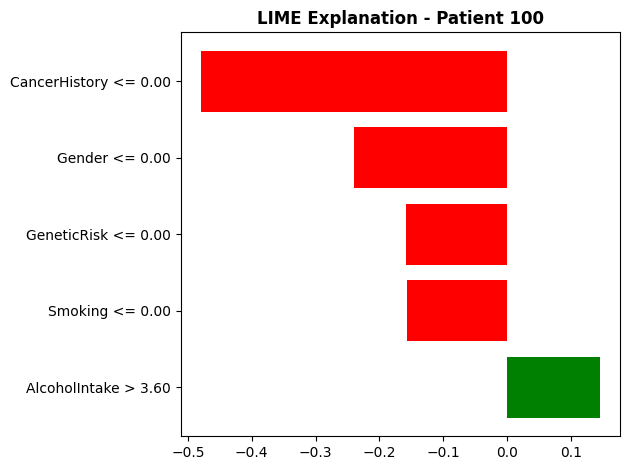


--- Patient 150 ---
Actual: No Cancer
Predicted: No Cancer
Probability: 0.0026


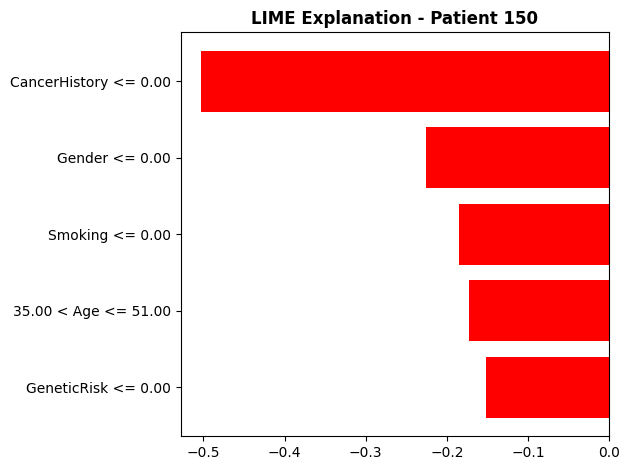


--- Patient 200 ---
Actual: Cancer
Predicted: Cancer
Probability: 0.9858


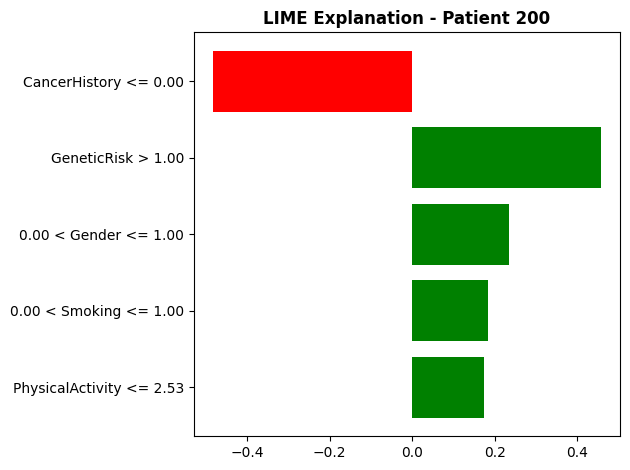

In [434]:
print("\n" + "="*60)
print("LIME (Local Interpretable Model-agnostic Explanations)")
print("="*60)

# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['No Cancer', 'Cancer'],
    mode='classification'
)

# %%
# LIME Explanation for First Test Patient

print("\n📊 LIME Explanation for First Test Patient:")
print("="*60)

# Generate explanation for first test instance
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[0].values,
    predict_fn=final_model.predict_proba,
    num_features=10
)

# Create matplotlib figure (avoiding IPython display issues)
fig = lime_exp.as_pyplot_figure()
plt.title("LIME Explanation - First Test Patient", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print feature contributions
print("\nLIME Feature Weights:")
lime_list = lime_exp.as_list()
for feature, weight in lime_list:
    print(f"{feature}: {weight:.4f}")

# Print prediction probabilities
print(f"\nPrediction Probabilities:")
print(f"No Cancer: {lime_exp.predict_proba[0]:.4f}")
print(f"Cancer: {lime_exp.predict_proba[1]:.4f}")

# %%
# LIME Explanations for Multiple Patients

print("\n" + "="*60)
print("LIME EXPLANATIONS FOR MULTIPLE PATIENTS")
print("="*60)

# Select diverse patients (correct predictions and misclassifications)
sample_indices = [0, 50, 100, 150, 200]

for idx in sample_indices:
    if idx >= len(X_test):
        continue
    
    print(f"\n--- Patient {idx} ---")
    print(f"Actual: {'Cancer' if y_test.iloc[idx] == 1 else 'No Cancer'}")
    print(f"Predicted: {'Cancer' if y_pred[idx] == 1 else 'No Cancer'}")
    print(f"Probability: {y_pred_proba[idx]:.4f}")
    
    exp = lime_explainer.explain_instance(
        X_test.iloc[idx].values,
        final_model.predict_proba,
        num_features=5
    )
    
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation - Patient {idx}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


PARTIAL DEPENDENCE PLOTS (PDP)

Generating PDPs for top features: ['Gender', 'CancerHistory', 'AlcoholIntake', 'Age', 'BMI', 'PhysicalActivity']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 7 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Library/Framework

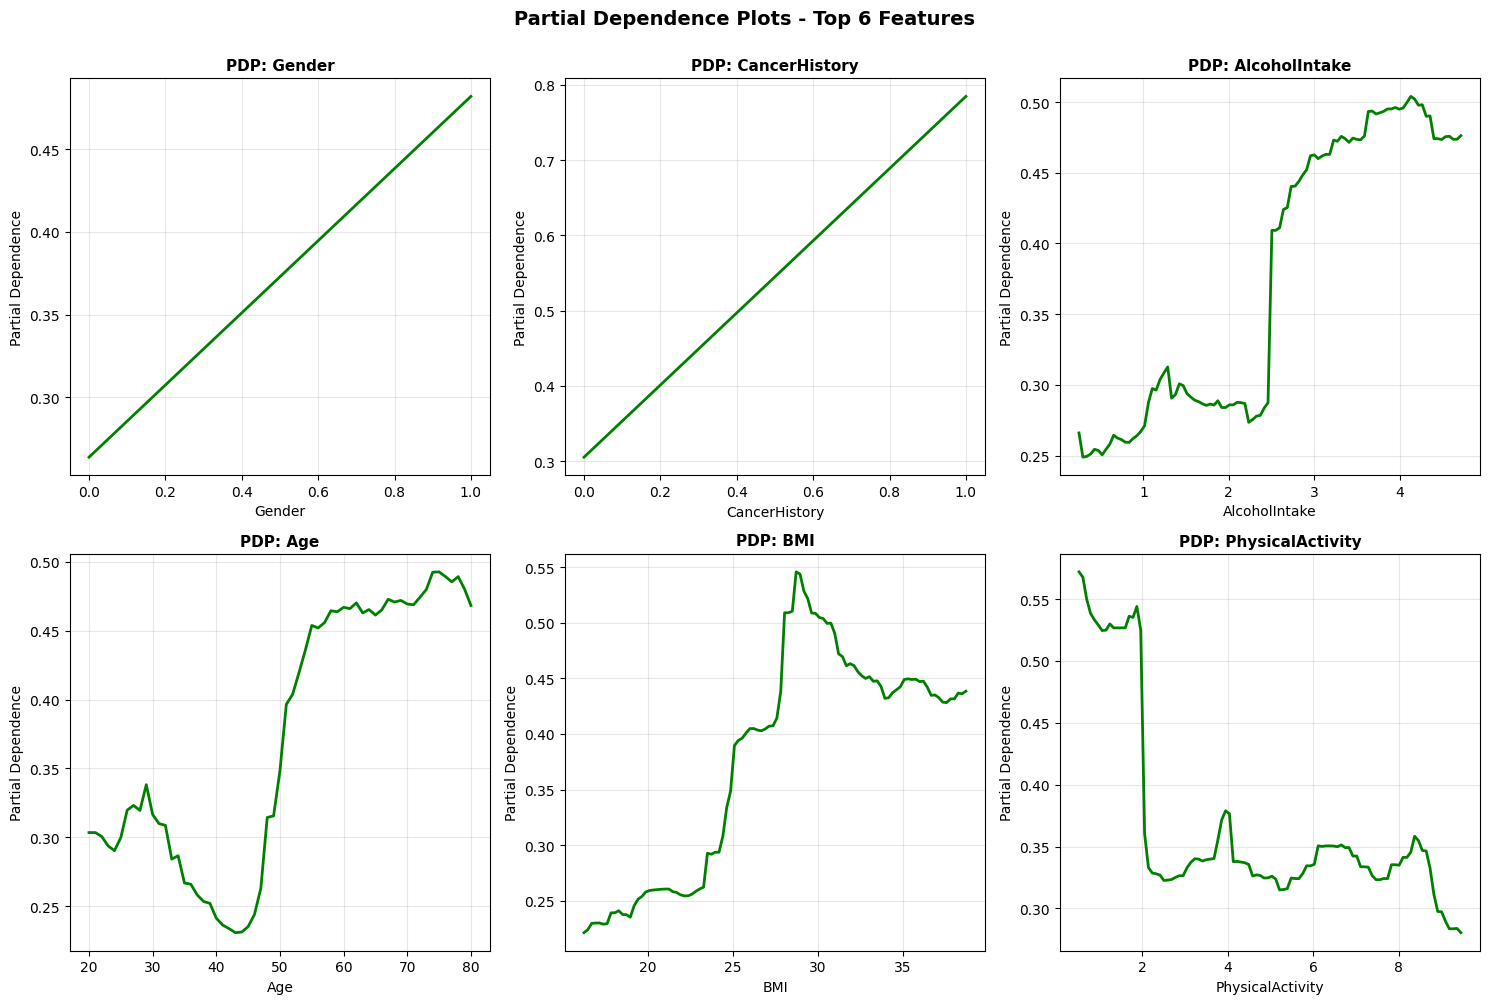


📊 2D Partial Dependence Plot for Top 2 Features:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Library/Framework

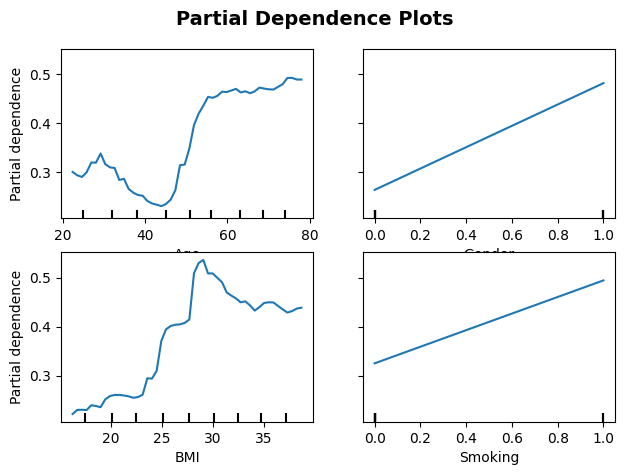

In [435]:
print("\n" + "="*60)
print("PARTIAL DEPENDENCE PLOTS (PDP)")
print("="*60)

# Select top features for PDP
top_pdp_features = shap_importance['Feature'].head(6).tolist()
print(f"\nGenerating PDPs for top features: {top_pdp_features}")

# %%
# PDP for Top Features (2x3 grid)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(top_pdp_features):
    feature_idx = X_train.columns.get_loc(feature)
    
    # Compute partial dependence
    pd_result = partial_dependence(
        final_model, 
        X_train, 
        features=[feature_idx],
        kind='average'
    )
    
    # Plot
    axes[i].plot(pd_result['grid_values'][0], pd_result['average'][0], 
                 color='green', linewidth=2)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Partial Dependence', fontsize=10)
    axes[i].set_title(f'PDP: {feature}', fontsize=11, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.suptitle('Partial Dependence Plots - Top 6 Features', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# %%
# Alternative: Using sklearn's PartialDependenceDisplay for 2D visualization

print("\n📊 2D Partial Dependence Plot for Top 2 Features:")

PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    features=[0, 1, 2, 3],  # First 4 features
    kind='average',
    n_cols=2,
    grid_resolution=50
)
plt.suptitle('Partial Dependence Plots', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



ICE PLOTS (Individual Conditional Expectation)

Generating ICE plots for: ['Gender', 'CancerHistory', 'AlcoholIntake', 'Age']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Library/Framework

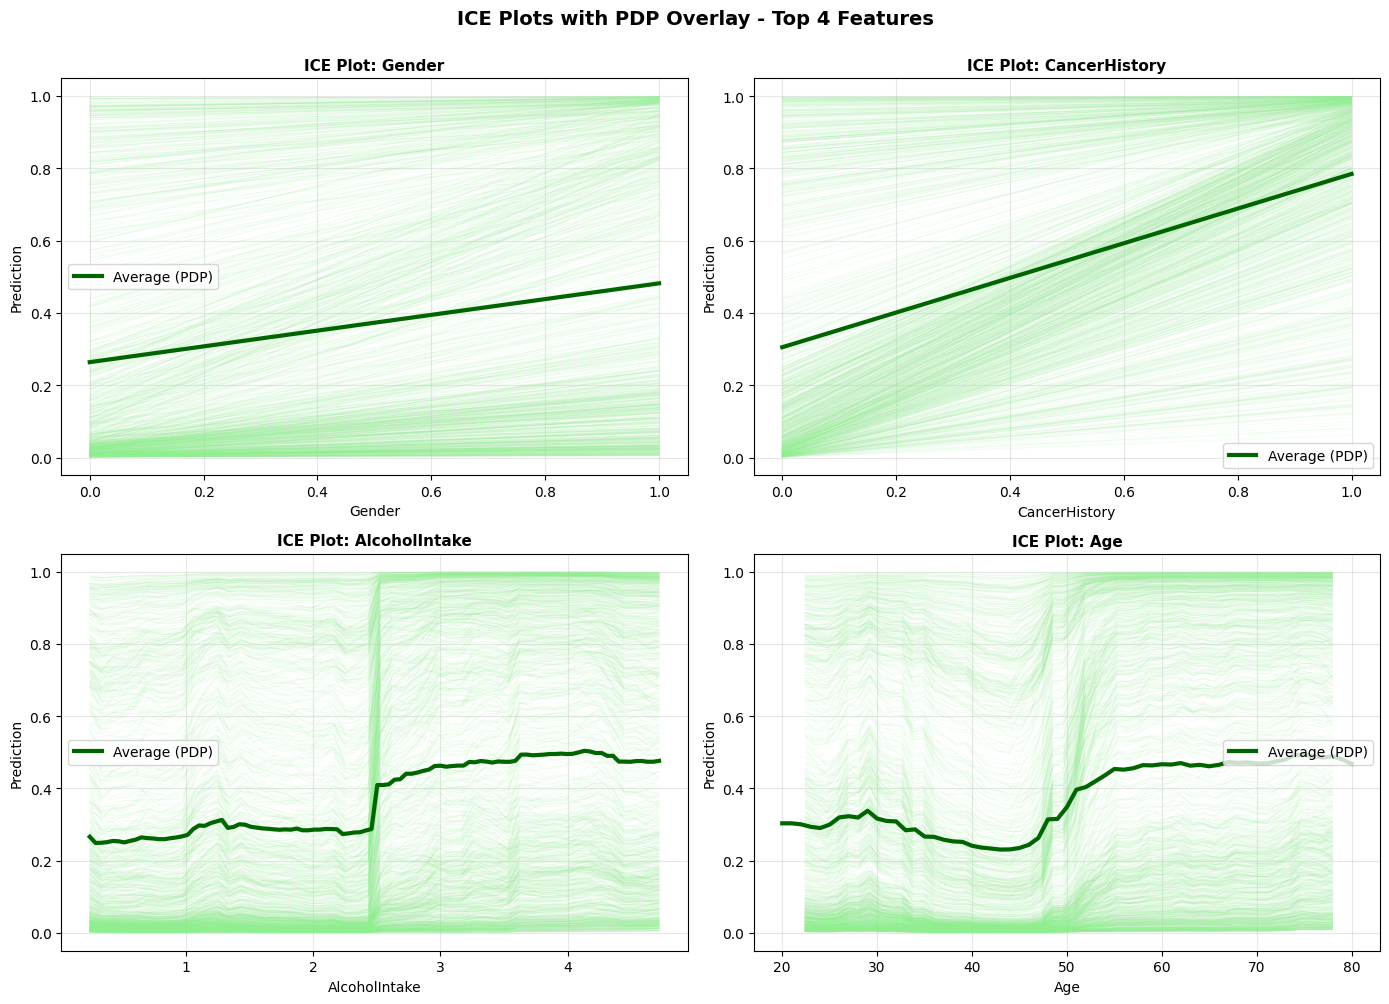


📊 Centered ICE Plots (c-ICE):


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 7 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Library/Framework

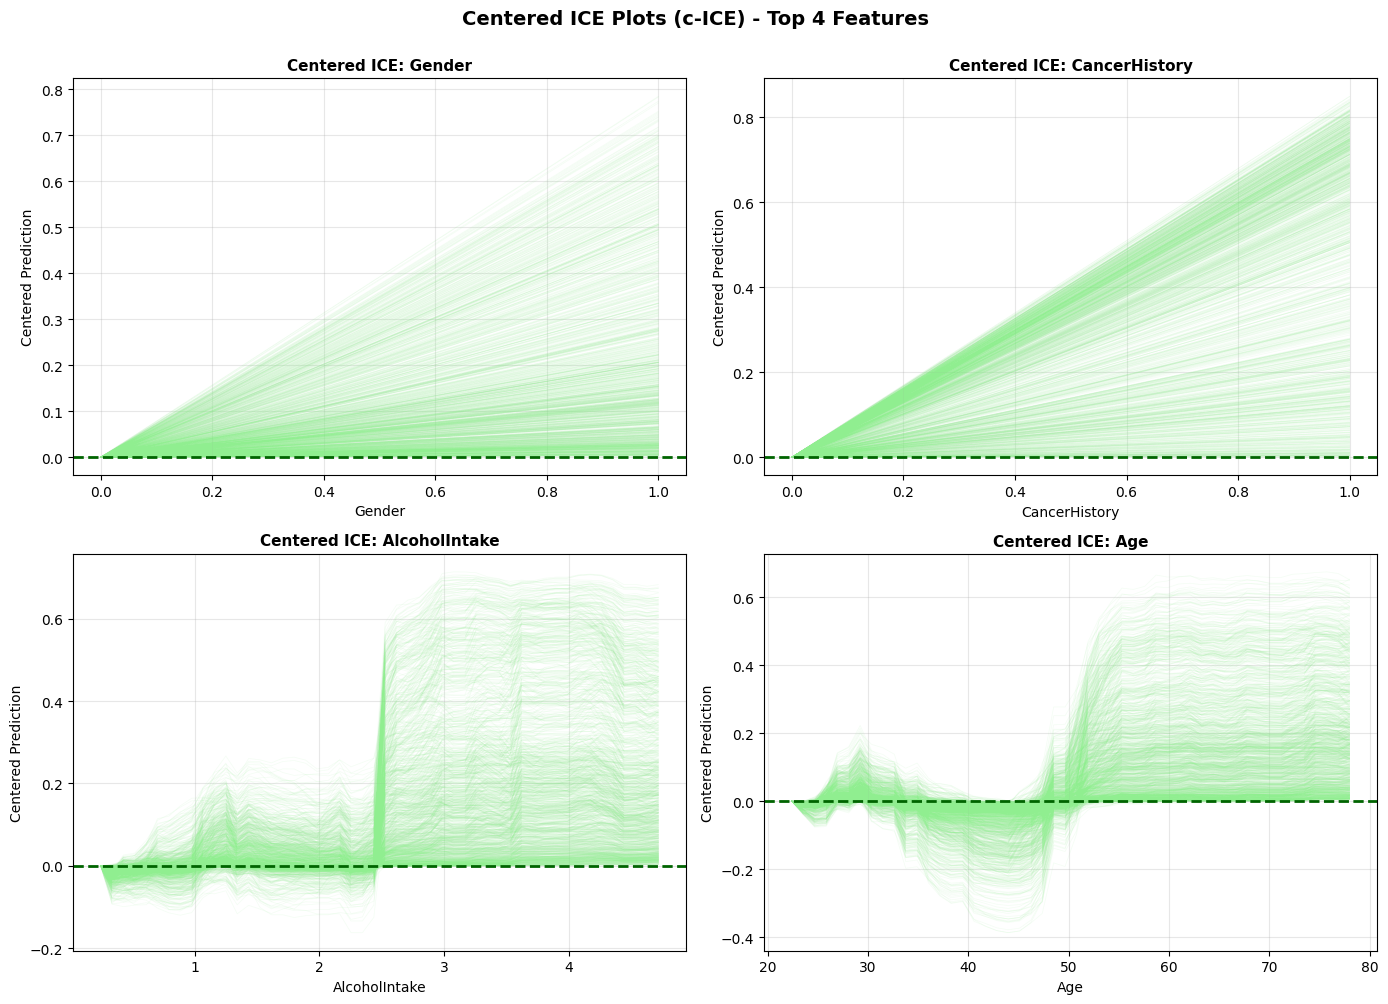

In [436]:
print("\n" + "="*60)
print("ICE PLOTS (Individual Conditional Expectation)")
print("="*60)

# ICE plots show how predictions change for individual instances

# %%
# ICE Plot for Top Features

top_ice_features = shap_importance['Feature'].head(4).tolist()
print(f"\nGenerating ICE plots for: {top_ice_features}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, feature in enumerate(top_ice_features):
    feature_idx = X_train.columns.get_loc(feature)
    
    # Compute ICE (individual lines)
    ice_result = partial_dependence(
        final_model,
        X_train,
        features=[feature_idx],
        kind='individual',
        grid_resolution=50
    )
    
    # Plot individual lines (ICE)
    for ice_line in ice_result['individual'][0]:
        axes[i].plot(ice_result['grid_values'][0], ice_line, 
                     color='lightgreen', alpha=0.1, linewidth=0.5)
    
    # Plot average (PDP) on top
    pd_result = partial_dependence(
        final_model,
        X_train,
        features=[feature_idx],
        kind='average'
    )
    axes[i].plot(pd_result['grid_values'][0], pd_result['average'][0],
                 color='darkgreen', linewidth=3, label='Average (PDP)')
    
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Prediction', fontsize=10)
    axes[i].set_title(f'ICE Plot: {feature}', fontsize=11, fontweight='bold')
    axes[i].legend(loc='best')
    axes[i].grid(alpha=0.3)

plt.suptitle('ICE Plots with PDP Overlay - Top 4 Features',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# %%
# Centered ICE Plots (c-ICE) - shows deviations from individual starting points

print("\n📊 Centered ICE Plots (c-ICE):")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, feature in enumerate(top_ice_features):
    feature_idx = X_train.columns.get_loc(feature)
    
    # Compute ICE
    ice_result = partial_dependence(
        final_model,
        X_train,
        features=[feature_idx],
        kind='individual',
        grid_resolution=50
    )
    
    # Center ICE lines (subtract first value)
    for ice_line in ice_result['individual'][0]:
        centered_line = ice_line - ice_line[0]
        axes[i].plot(ice_result['grid_values'][0], centered_line,
                     color='lightgreen', alpha=0.1, linewidth=0.5)
    
    # Add zero line
    axes[i].axhline(y=0, color='darkgreen', linestyle='--', linewidth=2)
    
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Centered Prediction', fontsize=10)
    axes[i].set_title(f'Centered ICE: {feature}', fontsize=11, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.suptitle('Centered ICE Plots (c-ICE) - Top 4 Features',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()